# Quantum Computing: Lab 2



## Working with real quantum devices (part 2)

After we have seen, how we can simulate existing quantum devices, we will now see how to run a quantum circuit on an existing quantum device.

In [1]:
from qiskit import *

# IBMQ.save_account('<API-Token>', hub='ibm-q', group='open', project='main', overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

In [2]:
from qiskit.providers.ibmq import least_busy

# get all real-hardware backends with more than one qubit
backends = list(filter(lambda device:device.configuration().num_qubits > 1, provider.backends(simulator=False, operational=True)))

lb_backend = least_busy(backends)    
print(lb_backend)

ibmq_lima


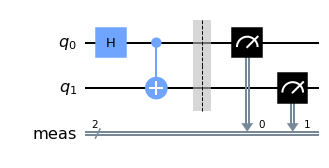

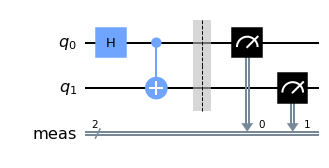

In [3]:
%matplotlib inline

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
from qiskit import BasicAer
from qiskit.tools.visualization import plot_histogram, plot_bloch_multivector

backend = BasicAer.get_backend('qasm_simulator')

bell_circuit = QuantumCircuit(2)
bell_circuit.h(0)
bell_circuit.cnot(0, 1)
bell_circuit.measure_all()
bell_circuit.draw('mpl')

In [4]:
job = execute(bell_circuit, backend, shots=1024)
bell_result = job.result()

In [5]:
bell_device_job = execute(bell_circuit, lb_backend, shots=1024)
bell_device_result = bell_device_job.result()
bell_device_result_counts = bell_device_result.get_counts(bell_circuit)

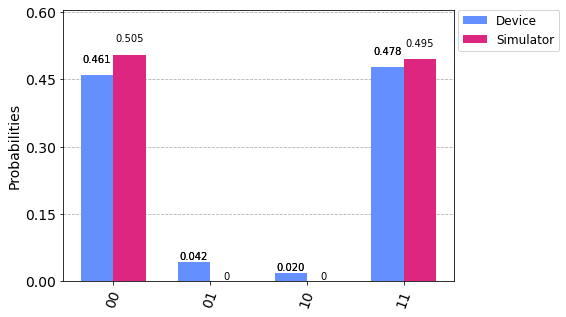

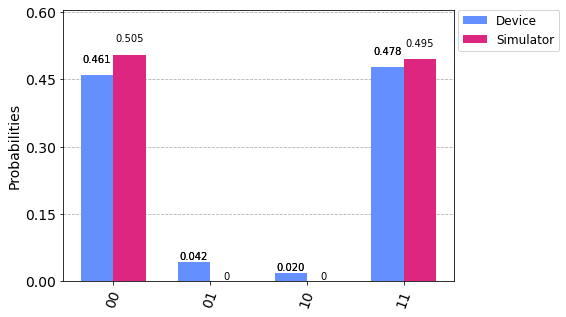

In [6]:
plot_histogram([bell_device_result_counts, bell_result.get_counts(bell_circuit)], legend=['Device', 'Simulator'])

## Developing the idea of quantum teleportation

- Alice has created a new hardware gate, which she wants to test
- Bob has a test lab, however Alice can't just bring her quantum computer to Bob
- Alice and Bob are far away from each other and thus want to exchange the state of a qubit, so that Bob can test it
- a classical copy is not possible, since it would involve measuring it and thus destroying its state

In [7]:
%matplotlib inline

from qiskit import *

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
from qiskit import BasicAer
from qiskit.tools.visualization import plot_histogram, plot_bloch_multivector

import numpy as np

backend = BasicAer.get_backend('qasm_simulator')

But first let us create our "special" gate

In [8]:
u_matrix = np.array([[np.sqrt(3)/np.sqrt(4), 1/np.sqrt(4)], [1/np.sqrt(4), -np.sqrt(3)/np.sqrt(4)]])
special_gate = qiskit.extensions.UnitaryGate(u_matrix, label="special")

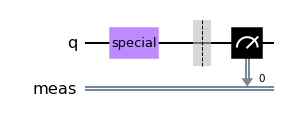

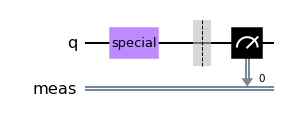

In [9]:
test_circuit = QuantumCircuit(1)
test_circuit.append(special_gate, [0]) # This is how we use our special gate
test_circuit.measure_all()
test_circuit.draw('mpl')

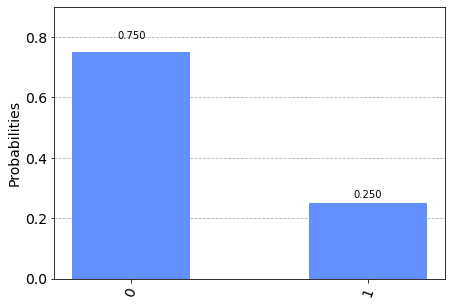

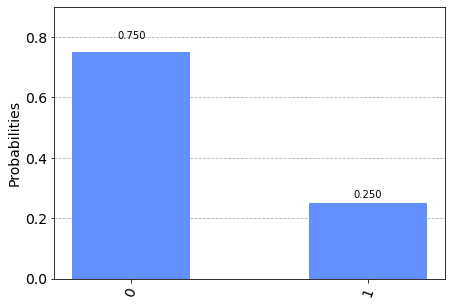

In [10]:
job_test = execute(test_circuit, backend, shots=1024)
test_result = job_test.result()
plot_histogram(test_result.get_counts(test_circuit))

- to see more precisely what happens, we want to use the `statevector_simulator`

In [11]:
statevector_backend = Aer.get_backend('statevector_simulator')

In [12]:
test_circuit_0 = QuantumCircuit(2)
test_circuit_0.append(special_gate, [1])

job_0 = execute(test_circuit_0, statevector_backend, optimization_level=0)
result_0 = job_0.result()

outputstate_0 = result_0.get_statevector(test_circuit_0)

print(outputstate_0)
print("Probailities:")
print("0: " + str(np.absolute(outputstate_0[0]) ** 2))
print("1: " + str(np.absolute(outputstate_0[2]) ** 2))

[0.8660254+0.j 0.       +0.j 0.5      +0.j 0.       +0.j]
Probailities:
0: 0.7499999999999999
1: 0.25


__Exercise 1:__ Write a circuit `test_circuit_1`, which simulates (using the `statevector_backend`) a circuit with qubit 1 starting in state $|1\rangle$

In [13]:
test_circuit_1 = QuantumCircuit(2)
test_circuit_1.x(1)
test_circuit_1.append(special_gate, [1])

job_1 = execute(test_circuit_1, statevector_backend, optimization_level=0)
result_1 = job_1.result()

outputstate_1 = result_1.get_statevector(test_circuit_1)

print(outputstate_1)
print("Probailities:")
print("0: " + str(np.absolute(outputstate_1[0]) ** 2))
print("1: " + str(np.absolute(outputstate_1[2]) ** 2))

[ 0.5      +0.j  0.       +0.j -0.8660254+0.j  0.       +0.j]
Probailities:
0: 0.25
1: 0.7499999999999999


- to start with an easier problem we want to move (not swap!) the state $|\psi\rangle$ from one qubit to another

__Exercise 2:__ Entangle both qubits!

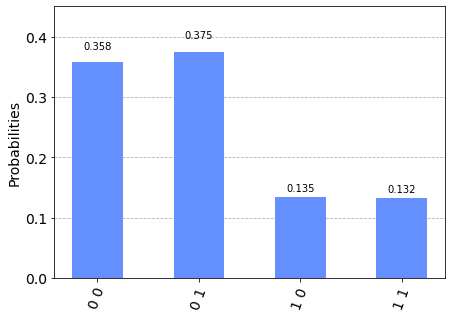

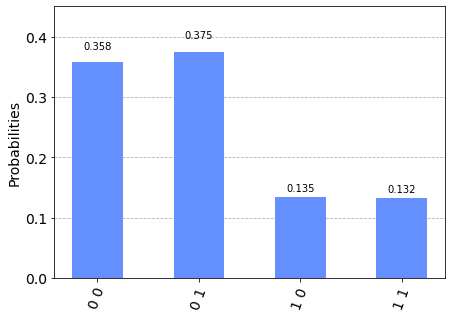

In [14]:
q_reg = QuantumRegister(2)
c_reg = ClassicalRegister(1)
result_reg = ClassicalRegister(1)

move_circuit = QuantumCircuit(q_reg, c_reg, result_reg)
move_circuit.append(special_gate, [0])

# Your Code here
move_circuit.cnot(q_reg[0], q_reg[1])

move_circuit.h(q_reg[0])
move_circuit.measure(q_reg[0], c_reg[0])

move_circuit.barrier()

move_circuit.z(q_reg[1]).c_if(c_reg, 1)

move_circuit.measure(q_reg[1], result_reg[0])

job_move = execute(move_circuit, backend)
result_move = job_move.result()

plot_histogram(result_move.get_counts(move_circuit))

We start on qubit 0 with state $\alpha|0\rangle + \beta|1\rangle$ and state $|0\rangle$ on qubit 1. (Instead of explicit amplitudes, we just want to use $\alpha$ an $\beta$)
So our complete state is at the moment: $\alpha|00\rangle + \beta|10\rangle$. To get rid of unwanted qubits, we can simply just measure them.

__Exercise 3:__ Analyse the states of quantum circuit above using equations (e.g. on paper or here with $\LaTeX$). What happened so far and what would happen next if we measure (1) in the computational basis or (2) in the +/- basis?

Some hints: 
- $|0\rangle$ in the +/- basis is $\frac{1}{\sqrt{2}}|+\rangle + \frac{1}{\sqrt{2}}|-\rangle$
- after rewriting the equation, what is the state of the second qubit if we measure $|+\rangle$ or $|-\rangle$

__Answer:__

Introduction of CNOT: $\alpha|00\rangle + \beta|11\rangle$

Rewritten with qubit 0 in +/- basis: $\alpha(\frac{1}{\sqrt{2}}|+\rangle + \frac{1}{\sqrt{2}}|-\rangle)|0\rangle + \beta(\frac{1}{\sqrt{2}}|+\rangle - \frac{1}{\sqrt{2}}|-\rangle)|1\rangle$

State of qubit 1 if we measure $|+\rangle$: $|+\rangle[\alpha|0\rangle + \beta|1\rangle]$
State of qubit 1 if we measure $|-\rangle$: $|-\rangle[\alpha|0\rangle - \beta|1\rangle]$

__Exercise 4:__ On IBM quantum computers (and most others) we can only measure in the Z-Basis (the computational basis). How could we still be able to measure in the +/- Basis using a Z-measurement? Add the needed actions to your `move_circuit`.

__Exercise 5:__ As we have seen before, if we measure in the +/- basis only one of the outcomes is correct. What could we do to change the outcome of the other one to the correct wanted state? (Answer here in the Markdown Cell or on paper)

__Answer:__ We need to execute the Z-Gate, if we measure $|-\rangle$

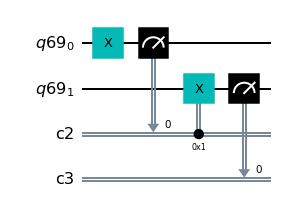

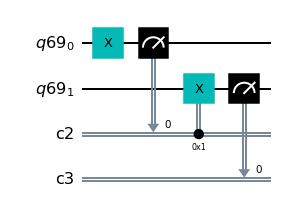

In [15]:
q_reg = QuantumRegister(2)
c_reg = ClassicalRegister(1)
c_reg2 = ClassicalRegister(1)

circ = QuantumCircuit(q_reg, c_reg, c_reg2)
circ.x(q_reg[0])
circ.measure(q_reg[0], c_reg[0])

circ.x(q_reg[1]).c_if(c_reg, 1)

circ.measure(q_reg[1], c_reg2[0])

circ.draw('mpl')

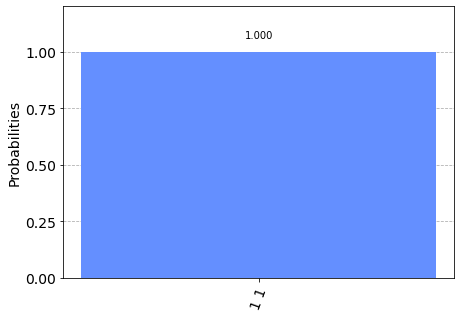

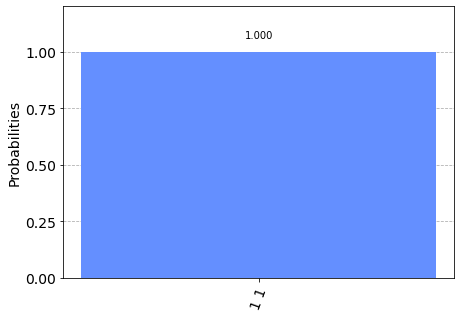

In [16]:
job_test = execute(circ, backend, shots=1024)
test_result = job_test.result()
plot_histogram(test_result.get_counts(circ))

__Exercise 6:__ Implement the conditional gate in your `move_circuit` and measure with the `qasm_simulator`. Also plot the circuit.

In [17]:
sub_result = qiskit.aqua.utils.get_subsystems_counts(result_move.get_counts(move_circuit))
plot_histogram(sub_result)

AttributeError: module 'qiskit' has no attribute 'aqua'

In [ ]:
move_circuit.draw('mpl')

Unfortunately we can't have a CNOT-Gate reaching from Alice to Bob. So we need a synchronization between our qubit 1 and a qubit from Bob.

__Exercise 7:__ How could we synchronize 2 qubits on completely different locations?

__Answer:__ Bell-State

__Exercise 8:__ Create a copy of your `move_circuit` here and implement your answer from exercise 7 on qubit 1 and 2 at the beginning of your circuit.

In [ ]:
q_reg = QuantumRegister(3, name='q_reg')
c_reg1 = ClassicalRegister(1, name='c_reg1')
c_reg2 = ClassicalRegister(1, name='c_reg2')
result_reg = ClassicalRegister(1, name='result')

move_circuit = QuantumCircuit(q_reg, c_reg1, c_reg2, result_reg)

move_circuit.h(q_reg[1])
move_circuit.cnot(q_reg[1], q_reg[2])

move_circuit.barrier()

move_circuit.append(special_gate, [0])

# Your Code here
move_circuit.cnot(q_reg[0], q_reg[1])

move_circuit.h(q_reg[0])
move_circuit.measure(q_reg[0], c_reg1[0])

move_circuit.barrier()

move_circuit.z(q_reg[2]).c_if(c_reg1, 1)

move_circuit.measure(q_reg[2], result_reg[0])

move_circuit.draw('mpl')

We now want to analyse the quantum circuit again, but without the measurements and the conditional gate.

We start in the following state: $\alpha|0\rangle + \beta|1\rangle(\frac{1}{\sqrt{2}}|00\rangle\frac{1}{\sqrt{2}}|11\rangle)$, which is the same as

$\frac{\alpha}{\sqrt{2}}|000\rangle + \frac{\alpha}{\sqrt{2}}|011\rangle + \frac{\beta}{\sqrt{2}}|100\rangle + \frac{\beta}{\sqrt{2}}|111\rangle$, afterwards we still apply the CNOT-Gate from qubit 0 to qubit 1

$\frac{\alpha}{\sqrt{2}}|000\rangle + \frac{\alpha}{\sqrt{2}}|011\rangle + \frac{\beta}{\sqrt{2}}|110\rangle + \frac{\beta}{\sqrt{2}}|101\rangle$

__Exercise 9:__ Create analyticly a measurement on qubit 1 (in either the computational basis or the +/- basis). Which conditional gate (if necessary) should be implemented to receive the following state: $\alpha|00\rangle + \beta|11\rangle$

__Answer:__ 

- We measure in the computational basis
- outcome 0: $\alpha|00\rangle + \beta|11\rangle$
- outcome 1: $\alpha|01\rangle + \beta|10\rangle$
- conditional X-Gate on qubit 2 results in $\alpha|00\rangle + \beta|11\rangle$

__Exercise 10:__ So now we are back where we were at the beginning. So now you can stitch everything together and create a quantum circuit for the qunatum teleportation.

In [ ]:
q_reg = QuantumRegister(3, name='q_reg')
c_reg1 = ClassicalRegister(1, name='c_reg1')
c_reg2 = ClassicalRegister(1, name='c_reg2')
result_reg = ClassicalRegister(1, name='result')

move_circuit = QuantumCircuit(q_reg, c_reg1, c_reg2, result_reg)

move_circuit.h(q_reg[1])
move_circuit.cnot(q_reg[1], q_reg[2])

move_circuit.barrier()

move_circuit.append(special_gate, [0])

# Your Code here
move_circuit.cnot(q_reg[0], q_reg[1])

move_circuit.measure(q_reg[1], c_reg2[0])

move_circuit.h(q_reg[0])
move_circuit.measure(q_reg[0], c_reg1[0])

move_circuit.barrier()

move_circuit.x(q_reg[2]).c_if(c_reg2, 1)
move_circuit.z(q_reg[2]).c_if(c_reg1, 1)

move_circuit.measure(q_reg[2], result_reg[0])

move_circuit.draw('mpl')

In [ ]:
job_move = execute(move_circuit, backend)
result_move = job_move.result()

plot_histogram(result_move.get_counts(move_circuit))

In [ ]:
sub_result = qiskit.aqua.utils.get_subsystems_counts(result_move.get_counts(move_circuit))
plot_histogram(sub_result)

## Deutsch-Jozsa Algorithm

Use the [IBM Quantum Experience](https://quantum-computing.ibm.com/composer) to implement a quantum circuit of the Deutsch-Jozsa Algorithm with 3 qubits for the balanced case. The general quantum circuit for the Deutsch Jozsa Algorithm can be found in the figure below. **Note that the last qubit starsts with state $|1\rangle$**. Remember, that we only measure our $|x\rangle$ qubits. So ignore the state of the last qubit (when reading the classical register its the first one, since its mirrored).

<img src="resources/deutschjozsa.jpg" alt="Deutsch-Jozsa Algorithm" style="width: 700px;"/> 

![](resources/circuit-deutschjozsa.png)